Initial setup

In [1]:
import wosis
import pandas as pd
import metaknowledge as mk
import json

C:\Users\douglasd\AppData\Local\Continuum\miniconda3\envs\biblio\lib\site-packages\fuzzywuzzy-0.17.0-py3.6.egg\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
# Helper functions for plotting
import wosis.analysis.plotting as wos_plot

# Analysis and search functions
from wosis.analysis import (preview_matches, search_records, keyword_matches, 
                            find_pubs_by_authors, preview_matches_by_keyword, get_unique_kw_titles,
                            remove_by_journals, remove_by_title)

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# This just helps make the plots look nicer
sns.set_style('darkgrid')
sns.set_context('paper', font_scale=2.0)

In [3]:
# Read in data from temporary cache file
query_id = "_756d39801152fe5f5f4ad3a3df9b6a30"
RC = mk.RecordCollection("tmp/{}.txt".format(query_id))

expected_num_records = 10694
num_records = len(RC)

assert num_records == expected_num_records, \
    "Mismatch in number of records - expected {}, got {}".format(expected_num_records, num_records)

print("Corpora consists of", num_records, "Publications")

Corpora consists of 10694 Publications


In [4]:
corpora_df = wosis.rec_to_df(RC)

corpora_df, removed_pubs = wosis.constrain.remove_empty_DOIs(corpora_df)

Removing 880 records with no DOIs


In [5]:
# removed_pubs

In [6]:
# Checking if expected paper is in corpora
corpora_df.loc[corpora_df['DOI'] == '10.1016/j.jocs.2015.08.008', :]

,id,year,title,keywords,abstract,AU,SO,DE,DOI
9421,WOS:000367774700005,2015,Chaospy: An open source tool for designing met...,,the paper describes the philosophy design func...,"Feinberg, Jonathan|Langtangen, Hans Petter",JOURNAL OF COMPUTATIONAL SCIENCE,uncertainty quantification|polynomial chaos ex...,10.1016/j.jocs.2015.08.008


In [7]:
# Hiding keywords and abstract for tutorial (WoS-owned IP)
hide_columns = ['DE', 'abstract', 'keywords', 'DOI', 'id', 'kws']
corpora_df.loc[:, ~corpora_df.columns.isin(hide_columns)].head()  # display first 5

,year,title,AU,SO
0,2017,Correlated Parameters Uncertainty Propagation ...,"Razmkhah, Homa|AkhoundAli, Ali-Mohammad|Radman...",ENVIRONMENTAL MODELING & ASSESSMENT
1,2016,"Uncertainty analysis in 2,3,7,8-tetrachlorodib...","Dong, Zhaomin|Yuan, Guanxiang|Hu, Jianying",ENVIRONMENT INTERNATIONAL
2,2012,A comparison of eight metamodeling techniques ...,"Villa-Vialaneix, Nathalie|Follador, Marco|Ratt...",ENVIRONMENTAL MODELLING & SOFTWARE
3,2017,A Support Vector Machine for Landslide Suscept...,"Lee, Saro|Hong, Soo-Min|Jung, Hyung-Sup",SUSTAINABILITY
4,2011,Social cost-benefit analysis of intensive vers...,"Bhattacharya, Poulomi|Ninan, K. N.",NATURAL RESOURCES FORUM


In [8]:
# Create a new metaknowledge collection
filtered_corpora = wosis.extract_recs(corpora_df.loc[:, 'id'], RC, name='Filtered Corpora')

<hr>

Plot keyword trend

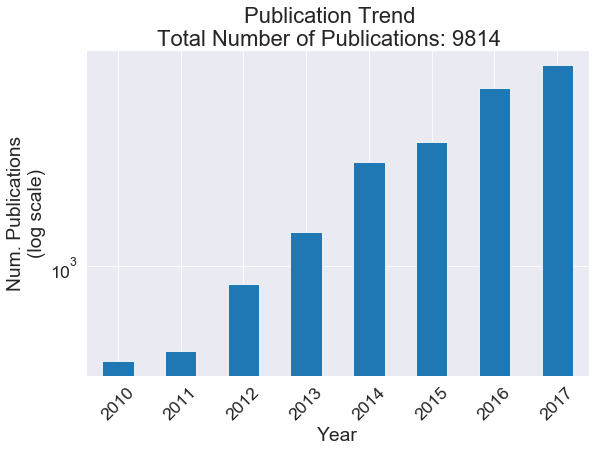

In [9]:
# Plot out the keyword trend. Can save the plot as an image if you give it a file location (will be saved in PNG format)
wos_plot.plot_pub_trend(filtered_corpora, title='Publication Trend', save_plot_fn=False)

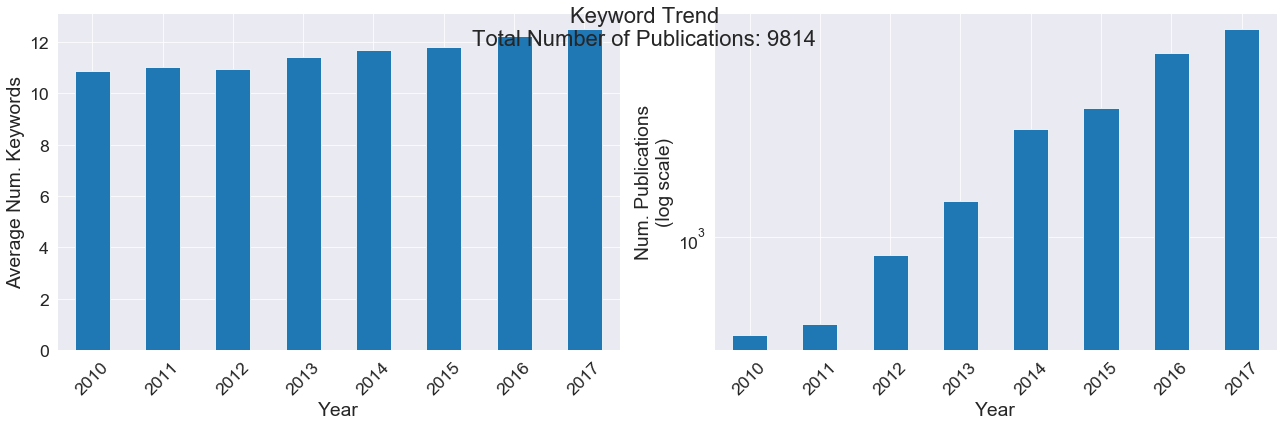

In [10]:
# Plot out the keyword trend. Can save the plot as an image if you give it a file location (will be saved in PNG format)
wos_plot.plot_kw_trend(filtered_corpora, title='Keyword Trend', save_plot_fn=r'C:\UserData\douglasd\project\biblio\uasa-trends\notebooks\pub_trend.png')

<hr>

Run topic model

In [11]:
from wosis.analysis import find_topics, get_topic_by_id

filtered_corpora_df = wosis.rec_to_df(filtered_corpora)
topic_model, trans, feature_names = find_topics(filtered_corpora_df, num_topics=5)

Topic 1: model uncertainty models parameters analysis data parameter sensitivity method modeling
Topic 2: optimization design method topology problem shape algorithm problems proposed optimal
Topic 3: energy cycle environmental life emissions production assessment impact waste lca
Topic 4: water soil model river climate groundwater quality change runoff flow
Topic 5: risk exposure assessment health flood risks human hazard uncertainty vulnerability


In [12]:
topic_pubs = {
    'model': get_topic_by_id(topic_model, trans, 1, filtered_corpora_df),
    # 'UA': get_topic_by_id(topic_model, trans, 8, filtered_corpora_df),
    # 'SA': get_topic_by_id(topic_model, trans, 20, filtered_corpora_df),    
}

# len(topic_pubs['model']), len(topic_pubs['UA'])
len(topic_pubs['model'])

3895

In [13]:
# find paper of interest - see if it's still in the corpora
for i in range(1,26):
    topic_set = get_topic_by_id(topic_model, trans, i, filtered_corpora_df)
    
    topic_recs = wosis.extract_recs(topic_set.loc[:, 'id'], RC, 'Topic of Interest')
    tmp_df = pd.DataFrame(topic_recs.forNLP(extraColumns=['DOI']))

    if len(tmp_df.loc[tmp_df["DOI"] == '10.1016/j.jocs.2015.08.008', :]) > 0:
        print("Found paper in topic", i)
        break

Found paper in topic 1


In [14]:
topic_set.loc[:, ~topic_set.columns.isin(hide_columns)].head(10)

,year,title,AU,SO
0,2017,Correlated Parameters Uncertainty Propagation ...,"Razmkhah, Homa|AkhoundAli, Ali-Mohammad|Radman...",ENVIRONMENTAL MODELING & ASSESSMENT
1,2016,"Uncertainty analysis in 2,3,7,8-tetrachlorodib...","Dong, Zhaomin|Yuan, Guanxiang|Hu, Jianying",ENVIRONMENT INTERNATIONAL
2,2012,A comparison of eight metamodeling techniques ...,"Villa-Vialaneix, Nathalie|Follador, Marco|Ratt...",ENVIRONMENTAL MODELLING & SOFTWARE
7,2013,Breast lesion co-localisation between X-ray an...,"Lee, Angela W. C.|Rajagopal, Vijayaraghavan|Ga...",MEDICAL IMAGE ANALYSIS
8,2014,Spline interpolation for modelling of accumula...,"Chervenkov, Hristo|Dimov, Ivan|Zlatev, Zahari",INTERNATIONAL JOURNAL OF ENVIRONMENT AND POLLU...
9,2014,Uncertainty quantification for the impact of i...,"Bao, Jie|Chu, Yanjun|Xu, Zhijie|Tartakovsky, A...",INTERNATIONAL JOURNAL OF GREENHOUSE GAS CONTROL
17,2012,Modeling secondary organic aerosol formation f...,"Parikh, Harshal M.|Carlton, Annmarie G.|Zhou, ...",ATMOSPHERIC ENVIRONMENT
19,2013,Variance Components and Generalized Sobol' Ind...,"Owen, Art B.",SIAM-ASA JOURNAL ON UNCERTAINTY QUANTIFICATION
21,2017,Remarks on multi-fidelity surrogates,"Park, Chanyoung|Haftka, Raphael T.|Kim, Nam H.",STRUCTURAL AND MULTIDISCIPLINARY OPTIMIZATION
22,2013,Uncertainty issues of a conceptual water balan...,"Li, Zhanling|Shao, Quanxi|Xu, Zongxue|Xu, Chon...",HYDROLOGICAL PROCESSES


In [15]:
topic_recs = wosis.extract_recs(topic_set.loc[:, 'id'], RC, 'Topic of Interest')

In [16]:
ua_topic_df = pd.DataFrame(topic_recs.forNLP(extraColumns=["DOI"]))

ua_topic_df.loc[ua_topic_df["DOI"] == '10.1016/j.jocs.2015.08.008', :]

,id,year,title,keywords,abstract,DOI
2017,WOS:000367774700005,2015,Chaospy: An open source tool for designing met...,,the paper describes the philosophy design func...,10.1016/j.jocs.2015.08.008


In [17]:
rec = RC.getID('WOS:000367774700005')
rec

<metaknowledge.WOSRecord object WOS:000367774700005>

<hr>

Plot journal trend of topic 1, see top publications by citation

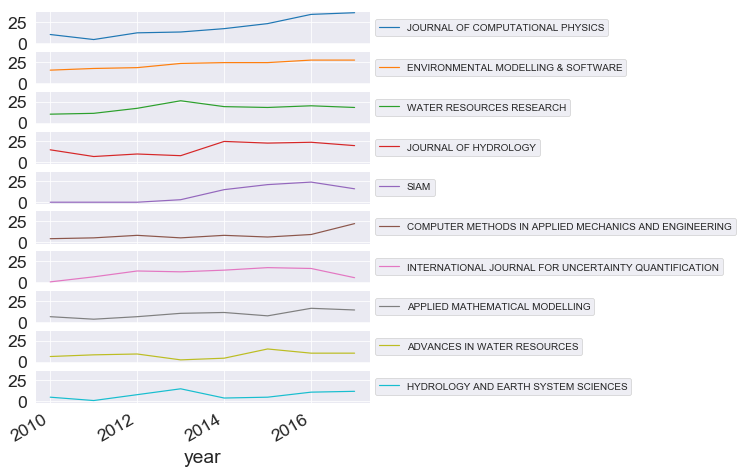

In [18]:
wos_plot.plot_journal_pub_trend(topic_recs)

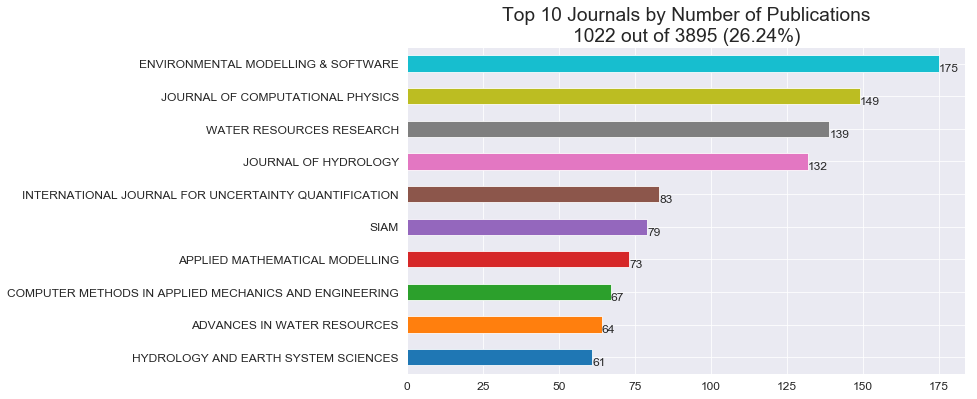

In [19]:
wos_plot.plot_pubs_per_journal(topic_recs, top_n=10, annotate=True, show_stats=True)

In [20]:
wosis.analysis.pub_citations(topic_recs)[0:50]
#ideas: could take first 1000 by citation number, but higher citations would favour older papers.  Taking by year?
#or simply choose first 1000 matches?

,Citations
Publication,
"Saltelli, A, 2002, Making best use of model evaluations to compute sensitivity indices, COMPUTER PHYSICS COMMUNICATIONS, 145, 280, 26483090",949
"Beven, K, 2001, Equifinality, data assimilation, and uncertainty estimation in mechanistic modelling of complex environmental systems using the GLUE methodology, JOURNAL OF HYDROLOGY, 249, 11, 279450",592
"Xiu, DB, 2005, High-order collocation methods for differential equations with random inputs, SIAM JOURNAL ON SCIENTIFIC COMPUTING, 27, 1118, 65700615",431
"Sobol, I. M., 1993, Sensitivity analysis for nonlinear mathematical models, Math. Model. Comput. Exp., 1, 407, 2602363",288
"Saltelli, Andrea, 2010, How to avoid a perfunctory sensitivity analysis, ENVIRONMENTAL MODELLING & SOFTWARE, 25, 1508, 338424851",263
"Vrugt, Jasper A., 2008, Treatment of input uncertainty in hydrologic modeling: Doing hydrology backward with Markov chain Monte Carlo simulation, WATER RESOURCES RESEARCH, 44, 261812426",257
"Sobol, IM, 2001, Global sensitivity indices for nonlinear mathematical models and their Monte Carlo estimates, MATHEMATICS AND COMPUTERS IN SIMULATION, 55, 271, 1049401",247
"MORRIS, MD, 1991, FACTORIAL SAMPLING PLANS FOR PRELIMINARY COMPUTATIONAL EXPERIMENTS, TECHNOMETRICS, 33, 161, 6699066",228
"Ghanem, R. G., 1991, Stochastic Finite Elements: A Spectral Approach, 277481739",203


In [21]:
topic_df = wosis.link_to_pub(topic_recs)  # Creates a new column called 'DOI link'
topic_df.loc[:, ~topic_df.columns.isin(hide_columns)].head(10)

,year,title,AU,SO,DOI link
0,2012,Sensitivity Analysis of a Combined Groundwater...,"Gedeon, Matej|Mallants, Dirk",MATHEMATICAL GEOSCIENCES,https://dx.doi.org/10.1007/s11004-012-9416-3
1,2017,Correlated Parameters Uncertainty Propagation ...,"Razmkhah, Homa|AkhoundAli, Ali-Mohammad|Radman...",ENVIRONMENTAL MODELING & ASSESSMENT,https://dx.doi.org/10.1007/s10666-017-9569-z
2,2016,"Uncertainty analysis in 2,3,7,8-tetrachlorodib...","Dong, Zhaomin|Yuan, Guanxiang|Hu, Jianying",ENVIRONMENT INTERNATIONAL,https://dx.doi.org/10.1016/j.envint.2015.12.010
3,2016,Optimal control of methicillin-resistant Staph...,"Agusto, F. B.",APPLIED MATHEMATICAL MODELLING,https://dx.doi.org/10.1016/j.apm.2015.12.006
4,2016,Sensitivity of a third generation wave model t...,"Siadatmousavi, S. Mostafa|Jose, Felix|da Silva...",COMPUTERS & GEOSCIENCES,https://dx.doi.org/10.1016/j.cageo.2015.09.025
5,2012,A comparison of eight metamodeling techniques ...,"Villa-Vialaneix, Nathalie|Follador, Marco|Ratt...",ENVIRONMENTAL MODELLING & SOFTWARE,https://dx.doi.org/10.1016/j.envsoft.2011.05.003
6,2015,Parallel tensor sampling in the hierarchical T...,"Grasedyck, Lars|Kriemann, Ronald|Loebbert, Chr...",COMPUTING AND VISUALIZATION IN SCIENCE,https://dx.doi.org/10.1007/s00791-015-0247-x
7,2013,Breast lesion co-localisation between X-ray an...,"Lee, Angela W. C.|Rajagopal, Vijayaraghavan|Ga...",MEDICAL IMAGE ANALYSIS,https://dx.doi.org/10.1016/j.media.2013.05.011
8,2014,Spline interpolation for modelling of accumula...,"Chervenkov, Hristo|Dimov, Ivan|Zlatev, Zahari",INTERNATIONAL JOURNAL OF ENVIRONMENT AND POLLU...,https://dx.doi.org/10.1504/IJEP.2014.064048
9,2014,Uncertainty quantification for the impact of i...,"Bao, Jie|Chu, Yanjun|Xu, Zhijie|Tartakovsky, A...",INTERNATIONAL JOURNAL OF GREENHOUSE GAS CONTROL,https://dx.doi.org/10.1016/j.ijggc.2013.10.023


<hr>

Further analysis of topic model results: <br>
- Search papers in topic of interest by keyword
- Run criteria search on topic of interest
- Want to list these papers into a table to export to csv, this was formally achieved in an old notebook
- Plot trend in criteria matches

In [22]:
# find papers of interest - having certain keywords

topic_set = get_topic_by_id(topic_model, trans, 2, filtered_corpora_df)

topic_recs = wosis.extract_recs(topic_set.loc[:, 'id'], RC, 'Topic of Interest')
# tmp_df = pd.DataFrame(topic_recs.forNLP(extraColumns=['DE']))
# need this next command to be keywords including ... eg uncertainty

tmp_df.loc[tmp_df["keywords"].str.contains("UNCERTAINTY"), :].head()
# some more ideas: filter topic 2 by papers with sensitivity in title/keywords/abstract to decrease size of dataset.
# might work for topic 1 as well?

,id,year,title,keywords,abstract,DOI
3,WOS:000374367500035,2016,Optimal control of methicillin-resistant Staph...,RANDOMIZED CLINICAL-TRIAL|SENSITIVITY-ANALYSIS...,methicillinresistant staphylococcus aureus mrs...,10.1016/j.apm.2015.12.006
13,WOS:000303094300009,2012,Model emulation and moment-independent sensiti...,UNCERTAINTY IMPORTANCE MEASURE|POLYNOMIAL CHAO...,momentindependent sensitivity methods are attr...,10.1016/j.envsoft.2011.06.006
18,WOS:000396233500009,2017,Calibration of the 1D shallow water equations:...,ADJOINT SENSITIVITY-ANALYSIS|OPEN-CHANNEL|ROUG...,the calibration of parameters in complex syste...,10.2166/hydro.2017.021
19,WOS:000293234900003,2011,The role of statistics in the analysis of ecos...,BAYESIAN NETWORK|MODELING APPROACH|DECISION-MA...,operationalising the holistic approach implici...,10.1002/env.1107
28,WOS:000313593500015,2013,Uncertainty issues of a conceptual water balan...,FORMAL BAYESIAN METHOD|PARAMETER UNCERTAINTY|H...,hydrological models are useful tools for bette...,10.1002/hyp.9258


In [23]:
#want to see trend of global SA over years
#also should make a table of papers, see below
criteria = {
    'LSA': set(['local sensitivity analysis', 'LSA', 'local sensitivity']),
    'GSA': set(['global sensitivity analysis', 'GSA', 'global sensitivity']),
    'OAT': set(['one-at-a-time', 'OAT'])
}

crit_matches, crit_summary = wosis.keyword_matches_by_criteria(filtered_corpora, criteria, threshold=95.0)

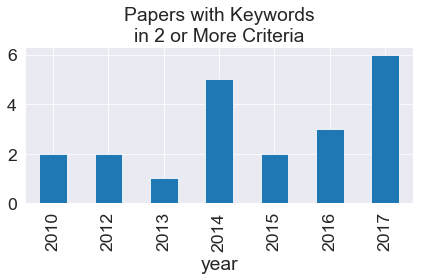

In [24]:
criteria_df = wosis.collate_keyword_criteria_matches(filtered_corpora, crit_matches)
wos_plot.plot_criteria_trend(criteria_df, threshold=2, save_plot_fn=r'C:\UserData\douglasd\project\biblio\uasa-trends\notebooks\kw_trend.png')

In [25]:
criteria_df.count()

id                    9814
year                  9814
title                 9814
keywords              9814
abstract              9814
num_criteria_match    9814
dtype: int64

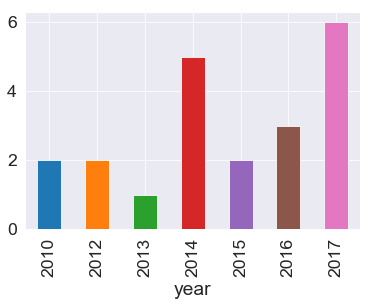

In [26]:
#want to view the papers in the above plot
crit_trend_tmp = criteria_df.loc[criteria_df['num_criteria_match'] > 1, ~criteria_df.columns.isin(hide_columns)]
#criteria_trend.loc[:, criteria_trend.columns.isin(hide_columns)].head(10)


crit_trend_tmp.groupby('year').count()['title'].plot(kind='bar')

In [27]:
crit_trend_tmp['title']

74            Making sense of global sensitivity analyses
368     SensSB: a software toolbox for the development...
716     Necessary condition for applying experimental ...
1246    Predicting the fate of micropollutants during ...
1620    Global sensitivity of structural variability b...
2139    Evaluating the Use of Global Sensitivity Analy...
2345    Sensitivity analysis of reference evapotranspi...
2715    Assessment of parametric uncertainty for groun...
4593    Global Sensitivity-Based Model Updating for He...
5488    Modeling Nitrogen Dynamics in a Waste Stabiliz...
5659    The use of global sensitivity analysis for imp...
6143    Distributed Evaluation of Local Sensitivity An...
6233    Parameter Sensitivity of a Surface Water Quali...
6948    Practical identifiability and uncertainty anal...
7133    Global sensitivity analysis: A flexible and ef...
7530    A non-probabilistic methodology for reliable s...
8118    Assessing greenhouse gas emissions of milk pro...
8361    Quanti

In [28]:
?wosis.keyword_matches

In [29]:
lsa_recs, lsa_summary = wosis.keyword_matches(filtered_corpora, criteria['LSA'], threshold=95.0)

In [30]:
from functools import reduce

In [31]:
lsa_collated = reduce(lambda x, y: x + y, list(lsa_recs.values()))

In [32]:
lsa_df = wosis.rec_to_df(lsa_collated)

In [33]:
gsa_recs, gsa_summary = wosis.keyword_matches(filtered_corpora, criteria['GSA'], threshold=95.0)
gsa_collated = reduce(lambda x, y: x + y, list(gsa_recs.values()))
gsa_df = wosis.rec_to_df(gsa_collated)

In [34]:
oat_recs, oat_summary = wosis.keyword_matches(filtered_corpora, criteria['OAT'], threshold=95.0)
oat_collated = reduce(lambda x, y: x + y, list(oat_recs.values()))
oat_df = wosis.rec_to_df(oat_collated)

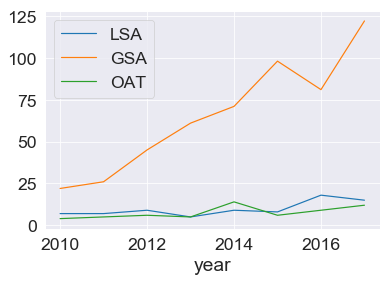

In [35]:
ax = lsa_df.groupby('year').count()['title'].plot(label="LSA", legend=True)
ax = gsa_df.groupby("year").count()['title'].plot(ax=ax, label="GSA", legend=True)
oat_df.groupby("year").count()['title'].plot(ax=ax, label="OAT", legend=True)